# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.037488,False,-0.174667
1,-0.523050,False,-1.292853
2,2.070420,True,9.443895
3,0.068183,False,1.113386
4,0.104074,True,5.843495
...,...,...,...
995,-0.265148,True,4.197523
996,-0.973204,False,-0.142424
997,-1.241690,False,-2.795862
998,-1.825721,False,-3.752621


<Axes: xlabel='v0'>

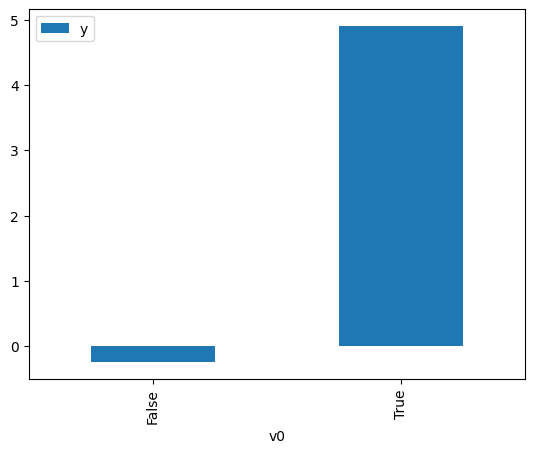

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

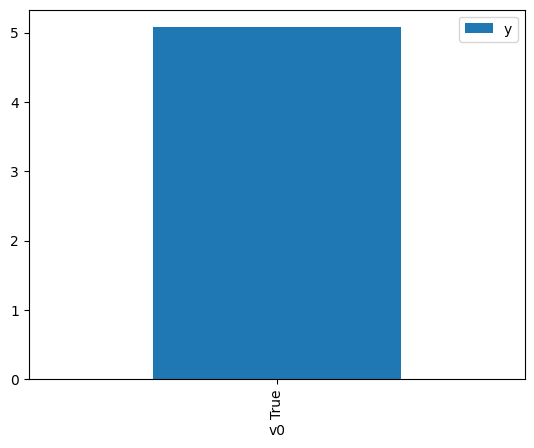

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.713942,False,-0.832839,0.774908,1.290476
1,0.378506,False,1.757012,0.329282,3.036907
2,-0.416285,False,-1.897409,0.669419,1.493834
3,-1.022786,False,-3.304443,0.856541,1.167486
4,0.541459,False,1.429673,0.268558,3.723594
...,...,...,...,...,...
995,-0.873678,False,0.280653,0.820688,1.218489
996,0.933586,False,2.296218,0.154328,6.479718
997,-0.961088,False,-1.653206,0.842488,1.186961
998,-0.057126,False,0.769879,0.516302,1.936850


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.752117,True,3.312724,0.213443,4.685087
1,-0.568538,True,4.378100,0.273487,3.656476
2,1.378671,True,7.617855,0.923760,1.082532
3,0.917073,True,6.610054,0.841791,1.187943
4,-0.871327,True,2.153620,0.179929,5.557742
...,...,...,...,...,...
995,0.260021,True,5.172035,0.622504,1.606415
996,3.495361,True,14.133175,0.998108,1.001895
997,-1.526145,True,1.050194,0.063908,15.647445
998,-0.324753,True,4.160558,0.367636,2.720078


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                          1.102e+04
Date:                Sun, 24 Nov 2024   Prob (F-statistic):                        0.00
Time:                        18:03:52   Log-Likelihood:                         -1410.0
No. Observations:                1000   AIC:                                      2824.
Df Residuals:                     998   BIC:                                      2834.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1425      0.034     63.535      0.000       2.076       2.209
x2             4.9804      0.048    103.470      0.000       4.886       5.075
==============================================================================
Omnibus:                        0.734   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.658
Skew:                           0.060   Prob(JB):                        0.720
Kurtosis:                       3.038   Cond. No.                         1.67
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""